# Assignment 2-Adaboost

## yumin cao, a1754926

# 1-- read file & preprocessing

In [1]:
import pandas as pd
import numpy as np
import math
import random
import time

np.random.seed(0)

In [2]:
input_path = '/Users/cao.yumin/Desktop/statistic_of_ml/2/data/wdbc_data.csv'
df = pd.read_csv(input_path,header=None)
df.drop(columns=[0],inplace=True)
'''
convert the labels into {-1,+1}
'''
df.replace({1: {'M': 1, 'B': -1}},inplace=True)
df

,1,2,3,4,5,6,7,8,9,10,...,22,23,24,25,26,27,28,29,30,31
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,1,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,1,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,1,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,1,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [3]:
'''
split train set and test set
'''
train = df.iloc[0:300,:]
train_x = df.iloc[0:300,1:] 
train_y = df.iloc[0:300,0:1]
test = df.iloc[300:,:]
test_x = df.iloc[300:,1:]
test_y = df.iloc[300:,0:1]

# 2-- class adaboost & class CART

In [4]:
'''
    Adaboost:
    input- training set; weak learner classifier
    output- final classifier G(x); train_test error curve with iterations
'''
class Adaboost:
    def __init__(self,train):
        self.train = train
        self.train_x = train.iloc[:,1:]
        self.train_y = train.iloc[:,0:1]
    '''
    Gini_CART_DT:

    Using CART method as decision stump
    Using (a_i+a_i+1)/2 as sort point r(threshold), to have x<r and x>r

    goal- find the minist gini index
    input- updated training set(with weight distribution Dm)
    return- all of the gini indexs; the optimal cut point
    '''
    def Gini_CART_DT(self,input_train,weight_list):
        weighted_train = input_train
        weighted_train_x = input_train.iloc[:,1:]
        weighted_train_y = input_train.iloc[:,0:1]
        self.weight_list = weight_list
        temp_list = []
        for i in range(len(weighted_train_x.columns)):
            target_column = weighted_train_x.iloc[:,i:i+1]
            target_column_x_y = pd.concat([weighted_train_y,target_column],axis=1)
            by_column = target_column_x_y.columns[1] # column name of target_column
            new_target_column = target_column_x_y.sort_values(by=by_column, axis=0, ascending = True)
            new_target_column_x = new_target_column.iloc[:,1:] # feature value after sorting
            new_target_column_y = new_target_column.iloc[:,0:1] # labels after sorting
            
            new_threshold = [] # 30 thresholds
            for k in range(int(new_target_column.shape[0]/10)):
                tlist = [0+10*k,9+10*k] # [0,9], [10,19]... threshold interval 10
                threshold = new_target_column_x.iloc[tlist[0]:tlist[0]+1,:].values[0]+\
                                           new_target_column_x.iloc[tlist[1]:tlist[1]+1,:].values[0]
                new_threshold.append(threshold[0])
            threshold_list = []
            for t in range(len(new_threshold)):
                error_raws_index1= [0]*new_target_column_x.shape[0] # list of index that wrongly classified
                error_raws_index2 = [0]*new_target_column_x.shape[0]
                error_raws_index = []
            
                for m in range(len(error_raws_index1)): # x<r +1; x>r -1
                    if target_column.iloc[m:m+1,:].values[0][0]<= new_threshold[t]:
                        if target_column_x_y.iloc[m:m+1,0:1].values[0][0]==-1:
                            error_raws_index1[m]=1
                    elif target_column.iloc[m:m+1,:].values[0][0]>new_threshold[t]:
                        if target_column_x_y.iloc[m:m+1,0:1].values[0][0]==1:
                            error_raws_index1[m]=1

                for m in range(len(error_raws_index2)): # x<r -1; x>r +1
                    if target_column.iloc[m:m+1,:].values[0][0]<=new_threshold[t]:
                        if target_column_x_y.iloc[m:m+1,0:1].values[0][0]==1:
                            error_raws_index2[m]=1
                    elif target_column.iloc[m:m+1,:].values[0][0]>new_threshold[t]:
                        if target_column_x_y.iloc[m:m+1,0:1].values[0][0]==-1:
                            error_raws_index2[m]=1

                if error_raws_index1.count(1) >= error_raws_index2.count(1):
                    error_raws_index = error_raws_index2
                    error_raws_index += ['-'] # x<r -1; x>r +1
                elif error_raws_index1.count(1) < error_raws_index2.count(1):
                    error_raws_index = error_raws_index1
                    error_raws_index += ['+'] # x<r +1; x>r -1
                    
                error = 0
                for s in range(len(self.weight_list)):
                    error += self.weight_list[s]* error_raws_index[s]
                threshold_list.append([error,new_threshold[t],error_raws_index])
            new_thresholdlist = sorted(threshold_list)  
            
            temp_list.append(new_thresholdlist[0]+[int(weighted_train_x.columns[i])])

        new_temp_list = sorted(temp_list) # get the minimum gini of all columns

        return new_temp_list[0] # [error, threshold, error_raws_index, column_name]

    def get_final_classifier(self):
        
        initial_weight = 1/self.train.shape[0]
        weight_list = [initial_weight]*self.train.shape[0]
        m = self.Gini_CART_DT(self.train,weight_list)
        error, threshold, error_raws_index, column_name,  = \
                                                    m[0],m[1],m[2],m[3]
        
        final_classifier = [] # recording alpha and the threshold of G(x)
        error_list = [] # recording error for plot
        column_names = []
        pn = [] # recording error_raws_index[-1] for classify x<r +1 or -1
        count=1 # count iteration
        random_number = np.random.random(self.train.shape[0]) 
        
        while error > 0.005:
            print('error:',error)
            pn.append(error_raws_index[-1])
            alpha = 1/2*math.log((1-error)/error)
            final_classifier.append((alpha,threshold))
            error_list.append(error)
            column_names.append(column_name)
            pn.append(error_raws_index[-1])
            
            Z = 0 # normalization factor Zm
            for r in range(len(error_raws_index[:-1])):
                if error_raws_index[r]==0:
                    p = weight_list[r]*math.exp(-alpha)
                    Z += p
                elif error_raws_index[r]==1:
                    p = weight_list[r]*math.exp(alpha)
                    Z += p
            print('Z',Z)
            
            for i in range(len(weight_list)): # update weight
                if error_raws_index[i] == 1:
                    weight_list[i] = weight_list[i]*math.exp(alpha)/Z
                elif error_raws_index[i] == 0:
                    weight_list[i] = weight_list[i]*math.exp(-alpha)/Z
            
#             print('%%',weight_list,len(weight_list))
            tp = 0
            for u in weight_list:
                tp+=u
#             print('%%',tp)
             
            a=0 # a is for calculating the interval
            interval_weight_list = [0] # generate interval, for example weight [1/6,1/2,1/3] 
                                      # then interval [1/6,1/6+1/2,1/6+1/2+1/3]
            sum = 0
            while a <= len(weight_list)-1:
                sum += weight_list[a]
                interval_weight_list.append(sum)
                a+=1
            
            new_train = pd.DataFrame(columns = self.train.columns.tolist())
                                           # new_train is the training set that following the data weight w1,w2...
            for j in range(len(random_number)):
                true = False
                for k in range(len(interval_weight_list)-1):
                    if true==True:
                        break
                    left_side = interval_weight_list[k]
                    right_side = interval_weight_list[k+1]
                    if (left_side<random_number[j]) and (random_number[j]<=right_side):
                        row = self.train.iloc[k:k+1,:]
#                         print('*****',row)
                        new_train = new_train.append(row,ignore_index = True)
                        true = True
        
            s = self.Gini_CART_DT(new_train,weight_list)
            error, threshold, error_raws_index,column_name = \
                                                    s[0],s[1],s[2],s[3]
            count += 1
            print('-----')
            
        print('>>',final_classifier)
        print('>>',error_list)
        print('>>',column_names)
        print('>>',count)
        print('>>',pn)
        self.count = count
        self.error_list = error_list
        return [final_classifier,error_list,column_names, count, pn]
    
    def Gx1(self,threshold,x): # G(x) = {+1,-1}
        if x<=threshold:
            return 1
        elif x>threshold:
            return -1
        
    def Gx2(self,threshold,x): # G(x) = {-1,+1}
        if x<=threshold:
            return -1
        elif x>threshold:
            return 1
        
    def predict(self,trainset,final_classifier,column_names,pn): # this is for getting the final results of G(x)
#         a = self.get_final_classifier()
#         final_classifier,error_list,column_names, count, pn= a[0],a[1],a[2],a[3],a[4]
        predict_label = []
        for j in range(trainset.shape[0]):
            result = 0 # final result G(x) = sign[alpha1G1(x)+alpha2G2(x)+...]
            for i in range(len(final_classifier)):
#                 print(trainset.loc[:,column_names[i]].values[j])
                if pn[i] == '+':
                    result += final_classifier[i][0]*self.Gx1(final_classifier[i][1],trainset.\
                                                              loc[:,column_names[i]].\
                                                         values[j])
                elif pn[i] == '-':
                    result += final_classifier[i][0]*self.Gx2(final_classifier[i][1],trainset.\
                                                              loc[:,column_names[i]].\
                                                         values[j])
#             print('result',result)
            if result<=0:
                predict_label.append(-1)
            elif result >0:
                predict_label.append(1)
        return predict_label
    
    def accuracy(self,y,predict_label):
        count = 0
        for i in range(y.shape[0]):
            if predict_label[i] == y.iloc[i:i+1,:].values[0][0]:
                count+=1
        accuracy = count/y.shape[0]
        return accuracy
    
    def prt(self):
        return [self.error_list,self.count]

In [5]:
time1 = time.time()
trainer = Adaboost(train)
f = trainer.get_final_classifier()
final_classifier,error_list,column_names, count, pn = f[0],f[1],f[2],f[3],f[4]
predict_label = trainer.predict(trainset=train_x,final_classifier=final_classifier,\
                                column_names=column_names,pn=pn)
accuracy = trainer.accuracy(train_y,predict_label)
time2 = time.time()
print('time',time2-time1)

error: 0.10333333333333326
Z 0.6087875016967901
-----
error: 0.11530159491545794
Z 0.6387711237224474
-----
error: 0.14366185220096067
Z 0.7014930489267881
-----
error: 0.08762076731747193
Z 0.565485166745048
-----
error: 0.06534667679465883
Z 0.4942731577844541
-----
error: 0.04420248430946111
Z 0.4110894048273826
-----
error: 0.0826374974789099
Z 0.5506670191298297
-----
error: 0.021992623028118163
Z 0.29331858148069107
-----
error: 0.02317012612789813
Z 0.30088716412047506
-----
error: 0.0370161051487884
Z 0.37760250586245914
-----
>> [(1.0803620875583468, 0.0461), (1.018847770894128, 824.2), (0.8926015205502861, 712.1), (1.1715188446364244, 834.1), (1.3302345484257034, 0.16161), (1.5368825466731488, 0.11928), (1.2035195827670657, 0.2639), (1.8974050663495459, 0.17549), (1.8707243618600289, 34.86), (1.6293417977462452, 3.215)]
>> [0.10333333333333326, 0.11530159491545794, 0.14366185220096067, 0.08762076731747193, 0.06534667679465883, 0.04420248430946111, 0.0826374974789099, 0.021992

In [6]:
a = trainer.prt()
error_list, count= a[0],a[1]
print('accuracy',accuracy)
print('predict',predict_label)
print('train_error',error_list)
print('iteration:',count)

accuracy 0.8933333333333333
predict [1, 1, 1, 1, 1, -1, 1, 1, 1, 1, -1, 1, 1, -1, 1, 1, 1, 1, 1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, 1, -1, -1, 1, -1, 1, -1, -1, -1, -1, -1, 1, -1, -1, 1, 1, -1, -1, -1, -1, 1, -1, 1, 1, -1, -1, -1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, -1, -1, 1, 1, -1, 1, 1, 1, -1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, -1, 1, 1, -1, -1, -1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, -1, -1, 1, -1, -1, 1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, 1, -1, -1, -1, 1, -1, -1, -1, -1, 1, 1, -1, 1, -1, -1, 1, 1, -1, -1, -1, 1, -1, -1, -1, -1, 1, -1, -1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, 1, -1, 1, 1, 1, 1, -1, 1, 1, 1, -1, -1, -1, 1, -1, -1, 1, -1, 1, 1, 1, -1, -1, -1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, -1, -1, 1, -1, -1, 1, 1, -1, 1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, 1, -1, 1, 1, 1, -1, 1, 1, 1, 1, 1, -1, 1, -1, 1, 1, -1, -1, -1, 

In [21]:
time3 = time.time()

final_classifier =  [(1.0803620875583468, 0.0461), (1.018847770894128, 824.2), (0.8926015205502861, 712.1),\
                     (1.1715188446364244, 834.1), (1.3302345484257034, 0.16161), (1.5368825466731488, 0.11928), \
                     (1.2035195827670657, 0.2639), (1.8974050663495459, 0.17549), (1.8707243618600289, 34.86),\
                     (1.6293417977462452, 3.215)]
column_names = [9, 25, 25, 25, 29, 8, 28, 29, 15, 14]
pn = ['-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-']
i = 1
accuracy1_list = []
while i<=11:
    final_classifier1 =  final_classifier[:i]
    column_names1 = column_names[:i]
    pn1 = pn[:i]
    predict_label1 = trainer.predict(trainset=test_x,final_classifier=final_classifier1,\
                                    column_names=column_names1,pn=pn1)
    accuracy1 = trainer.accuracy(test_y,predict_label1)
    print('accuracy1',accuracy1)
    accuracy1_list.append(accuracy1)
    i+=1
time4 = time.time()
print('time',time4-time3)

accuracy1 0.9107806691449815
accuracy1 0.9107806691449815
accuracy1 0.9144981412639405
accuracy1 0.9368029739776952
accuracy1 0.9368029739776952
accuracy1 0.9628252788104089
accuracy1 0.9591078066914498
accuracy1 0.9628252788104089
accuracy1 0.9814126394052045
accuracy1 0.9739776951672863
accuracy1 0.9739776951672863
time 0.8851468563079834


In [25]:
test_error_list = [1-accuracy1_list[i] for i in range(len(accuracy1_list))]
test_error_list
error_list+=[0.0043]

# 3-- control the iteration and plot

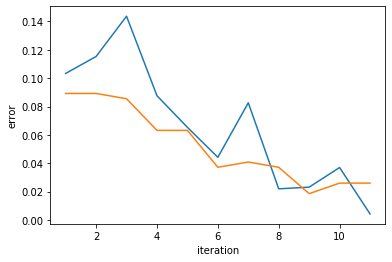

In [26]:
import matplotlib.pyplot as plt
plt.plot([i for i in range(1,12)], error_list)
plt.plot([i for i in range(1,12)], test_error_list)
plt.xlabel('iteration')
plt.ylabel('error')
plt.show()

# 4-- Train SVM model and get accuracy 

In [36]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
# build a svc without scaling the data

clf = SVC(C=1.0, 
          kernel='rbf',
          gamma='scale', 
          tol=0.001, 
          class_weight=None, 
          max_iter=-1)

clf_without_scale = SVC(C=1.0, 
                      kernel='rbf',
                      gamma='scale', 
                      tol=0.001, 
                      class_weight=None, 
                      max_iter=-1)
X_train, X_test, y_train, y_test =\
                     train_x.to_numpy(), test_x.to_numpy(), train_y.to_numpy().ravel(), test_y.to_numpy().ravel()

# First scale the data, then build svc
steps = [('scaler', StandardScaler()), ('svm', clf)]
clf_with_scale = Pipeline(steps)

# training svc using training dataset
clf_without_scale.fit(X_train, y_train)
clf_with_scale.fit(X_train, y_train)

# predict test dataset
y_pred_without_scale = clf_without_scale.predict(X_test)
y_pred_with_scale = clf_with_scale.predict(X_test)
print("Prediction report without scale:")
print(classification_report(y_test, y_pred_without_scale))
print("Prediction report with scale:")
print(classification_report(y_test, y_pred_with_scale))

Prediction report without scale:
              precision    recall  f1-score   support

          -1       0.98      0.91      0.94       203
           1       0.77      0.94      0.84        66

    accuracy                           0.91       269
   macro avg       0.87      0.92      0.89       269
weighted avg       0.93      0.91      0.92       269

Prediction report with scale:
              precision    recall  f1-score   support

          -1       1.00      0.98      0.99       203
           1       0.93      1.00      0.96        66

    accuracy                           0.98       269
   macro avg       0.96      0.99      0.98       269
weighted avg       0.98      0.98      0.98       269



In [33]:
from sklearn.model_selection import GridSearchCV

# split training data and testing data with a ratio of 7:3
X_train, X_test, y_train, y_test = \
                      train_x.to_numpy(), test_x.to_numpy(), train_y.to_numpy().ravel(), test_y.to_numpy().ravel()

# build the svm
clf = SVC(C=1.0, 
          kernel='rbf',
          gamma='scale', 
          tol=0.001, 
          class_weight=None, 
          max_iter=-1)

# build the pipeline
steps = [('scaler', StandardScaler()), ('svm', clf)]
pipeline = Pipeline(steps)

# perform a grid search
parameters = {'svm__C': [0.01, 0.1, 1, 10, 100, 1000], 'svm__gamma': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 'scale', 'auto']}
gs_clf = GridSearchCV(pipeline, parameters, cv=5)
gs_clf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('svm',
                                        SVC(C=1.0, break_ties=False,
                                            cache_size=200, class_weight=None,
                                            coef0=0.0,
                                            decision_function_shape='ovr',
                                            degree=3, gamma='scale',
                                            kernel='rbf', max_iter=-1,
                                            probability=False,
                                            random_state=None, shrinking=True,
                                            tol=0.001

In [34]:
print(gs_clf.best_params_)

{'svm__C': 1, 'svm__gamma': 0.01}


In [35]:
y_true, y_pred = y_test, gs_clf.predict(X_test)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

          -1       1.00      0.98      0.99       203
           1       0.94      1.00      0.97        66

    accuracy                           0.99       269
   macro avg       0.97      0.99      0.98       269
weighted avg       0.99      0.99      0.99       269

